# Applying Linear Discriminative analysics and Ensemble learning for MNIST Dataset

## Importing the necessary libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from joblib import Parallel, delayed
import time
import warnings
import os
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

## Loading the dataset and resampling it to reduce the computational complexicity

In [10]:
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

train_data.sample(n=20000, random_state=42)

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
12628      7    0    0    0    0    0    0    0    0    0  ...      0      0   
37730      3    0    0    0    0    0    0    0    0    0  ...      0      0   
39991      8    0    0    0    0    0    0    0    0    0  ...      0      0   
8525       9    0    0    0    0    0    0    0    0    0  ...      0      0   
8279       3    0    0    0    0    0    0    0    0    0  ...      0      0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
53300      4    0    0    0    0    0    0    0    0    0  ...      0      0   
10297      7    0    0    0    0    0    0    0    0    0  ...      0      0   
4540       4    0    0    0    0    0    0    0    0    0  ...      0      0   
24701      9    0    0    0    0    0    0    0    0    0  ...      0      0   
58800      3    0    0    0    0    0    0    0    0    0  ...      0      0   

       28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
12628      0      0      0      0      0      0      0      0  
37730      0      0      0      0      0      0      0      0  
39991      0      0      0      0      0      0      0      0  
8525       0      0      0      0      0      0      0      0  
8279       0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
53300      0      0      0      0      0      0      0      0  
10297      0      0      0      0      0      0      0      0  
4540       0      0      0      0      0      0      0      0  
24701      0      0      0      0      0      0      0      0  
58800      0      0      0      0      0      0      0      0  

[20000 rows x 785 columns]

## Seperating the features and target

In [11]:
X_train = train_data.iloc[:, 1:].values  
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values 
y_test = test_data.iloc[:, 0].values 

## Feture Selection Based on correlation

In [12]:
warnings.filterwarnings("ignore")

# Calculate the correlation matrix
correlations = pd.DataFrame(X_train).corrwith(pd.Series(y_train))

# Set a correlation threshold
threshold = 0.02

# Identify features with correlation above the threshold
relevant_features = np.where(np.abs(correlations) > threshold)[0]

# Filter the dataset to keep only the relevant features
X_train_relevant = X_train[:, relevant_features]
X_test_relevant = X_test[:, relevant_features]

# Print the number of features before and after reduction
print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_relevant.shape[1]}")


Original number of features: 784
Reduced number of features: 520


## Normalizing the Features

In [13]:
X_train_scaled = X_train_relevant / 255
X_test_scaled = X_test_relevant / 255

## Feature Extraction Based on LDA

In [17]:
warnings.filterwarnings("ignore") 

# Define models and their parameter grids
base_models = {
    "SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
}

# Extend models to include One-vs-Rest (OvA) and One-vs-One (OvO) classifiers
models = {}
for name, model in base_models.items():
    models[f"{name}"] = model
    models[f"One-vs-All ({name})"] = OneVsRestClassifier(model)
    models[f"One-vs-One ({name})"] = OneVsOneClassifier(model)

param_grids = {
    "SVM": {'C': [0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'kernel': ['rbf', 'poly'], 'degree' :[2, 3, 4]},
    "Random Forest": {'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 30, 40, None], 'max_features': ['sqrt', 'log2', None]},
    "Naive Bayes": {},
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga', 'lbfgs'],'penalty': ['l2', 'l1'],},
    "Decision Tree": {'max_depth': [10, 20, 30, 40, None], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf':[1,2,4]},
    "KNN": {'n_neighbors': [1, 3, 5, 7, 9],'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan','minkowski']},
}

n_classes = len(np.unique(y_train))
max_lda_components = 9 

def perform_random_search(model, param_grid, X, y):
    search_method = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
    search_method.fit(X, y)
    return search_method.best_estimator_, search_method.best_score_


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, name):
    print(f"\nTraining model: {name}")
    best_accuracy = 0
    best_model = None
    best_components = 0
    accuracy_list = []
    error_rates = np.zeros(10)
    start_time = time.time()
    
    for n_components in range(1, max_lda_components + 1): 
        if name == "SVM" and n_components == 1:
            continue
        
        lda = LDA(n_components=n_components)
        X_train_lda = lda.fit_transform(X_train, y_train)
        X_test_lda = lda.transform(X_test)

        best_current_model, best_score = perform_random_search(model, param_grids.get(name, {}), X_train_lda, y_train)

        y_pred = best_current_model.predict(X_test_lda)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
        
        print(f"Accuracy for {n_components} LDA components with {name}: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = best_current_model
            best_components = n_components

    end_time = time.time()
    training_time = end_time - start_time

    for i in range(len(y_test)):
        actual = y_test[i]
        predicted = y_pred[i]
        if actual != predicted:
            error_rates[actual] += 1

    total_counts = np.bincount(y_test, minlength=10)
    error_rates = error_rates / total_counts

    return {
        'model_name': name,
        'best_accuracy': best_accuracy,
        'best_model': best_model,
        'best_components': best_components,
        'accuracy_list': accuracy_list,
        'error_rates': error_rates,
        'training_time': training_time
    }

# Run models in parallel (including One-vs-All and One-vs-One classifiers)
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate_model)(model, X_train_scaled, y_train, X_test_scaled, y_test, name)
    for name, model in models.items()
)


In [20]:
for result in results:
    if result['model_name'] == 'SVM':
        result['accuracy_list'] = [None] + result['accuracy_list']

In [33]:
results

[{'model_name': 'SVM',
  'best_accuracy': 0.9275,
  'best_model': SVC(C=1, degree=4, gamma='auto', random_state=42),
  'best_components': 9,
  'accuracy_list': [None,
   0.573,
   0.7555,
   0.8393,
   0.85,
   0.8779,
   0.902,
   0.9193,
   0.9275],
  'error_rates': array([0.01836735, 0.02026432, 0.0746124 , 0.09306931, 0.05906314,
         0.1132287 , 0.05114823, 0.07587549, 0.12422998, 0.10505451]),
  'training_time': 29413.470187664032},
 {'model_name': 'One-vs-All (SVM)',
  'best_accuracy': 0.9176,
  'best_model': OneVsRestClassifier(estimator=SVC(random_state=42)),
  'best_components': 9,
  'accuracy_list': [0.3365,
   0.5323,
   0.7369,
   0.8345,
   0.8452,
   0.8714,
   0.8963,
   0.9106,
   0.9176],
  'error_rates': array([0.02244898, 0.02202643, 0.09108527, 0.10792079, 0.06619145,
         0.12556054, 0.05114823, 0.08268482, 0.14681725, 0.11892963]),
  'training_time': 8129.867125272751},
 {'model_name': 'One-vs-One (SVM)',
  'best_accuracy': 0.9232,
  'best_model': OneVsOn

## Visualizing the accuracy for binary and Multi class separetely

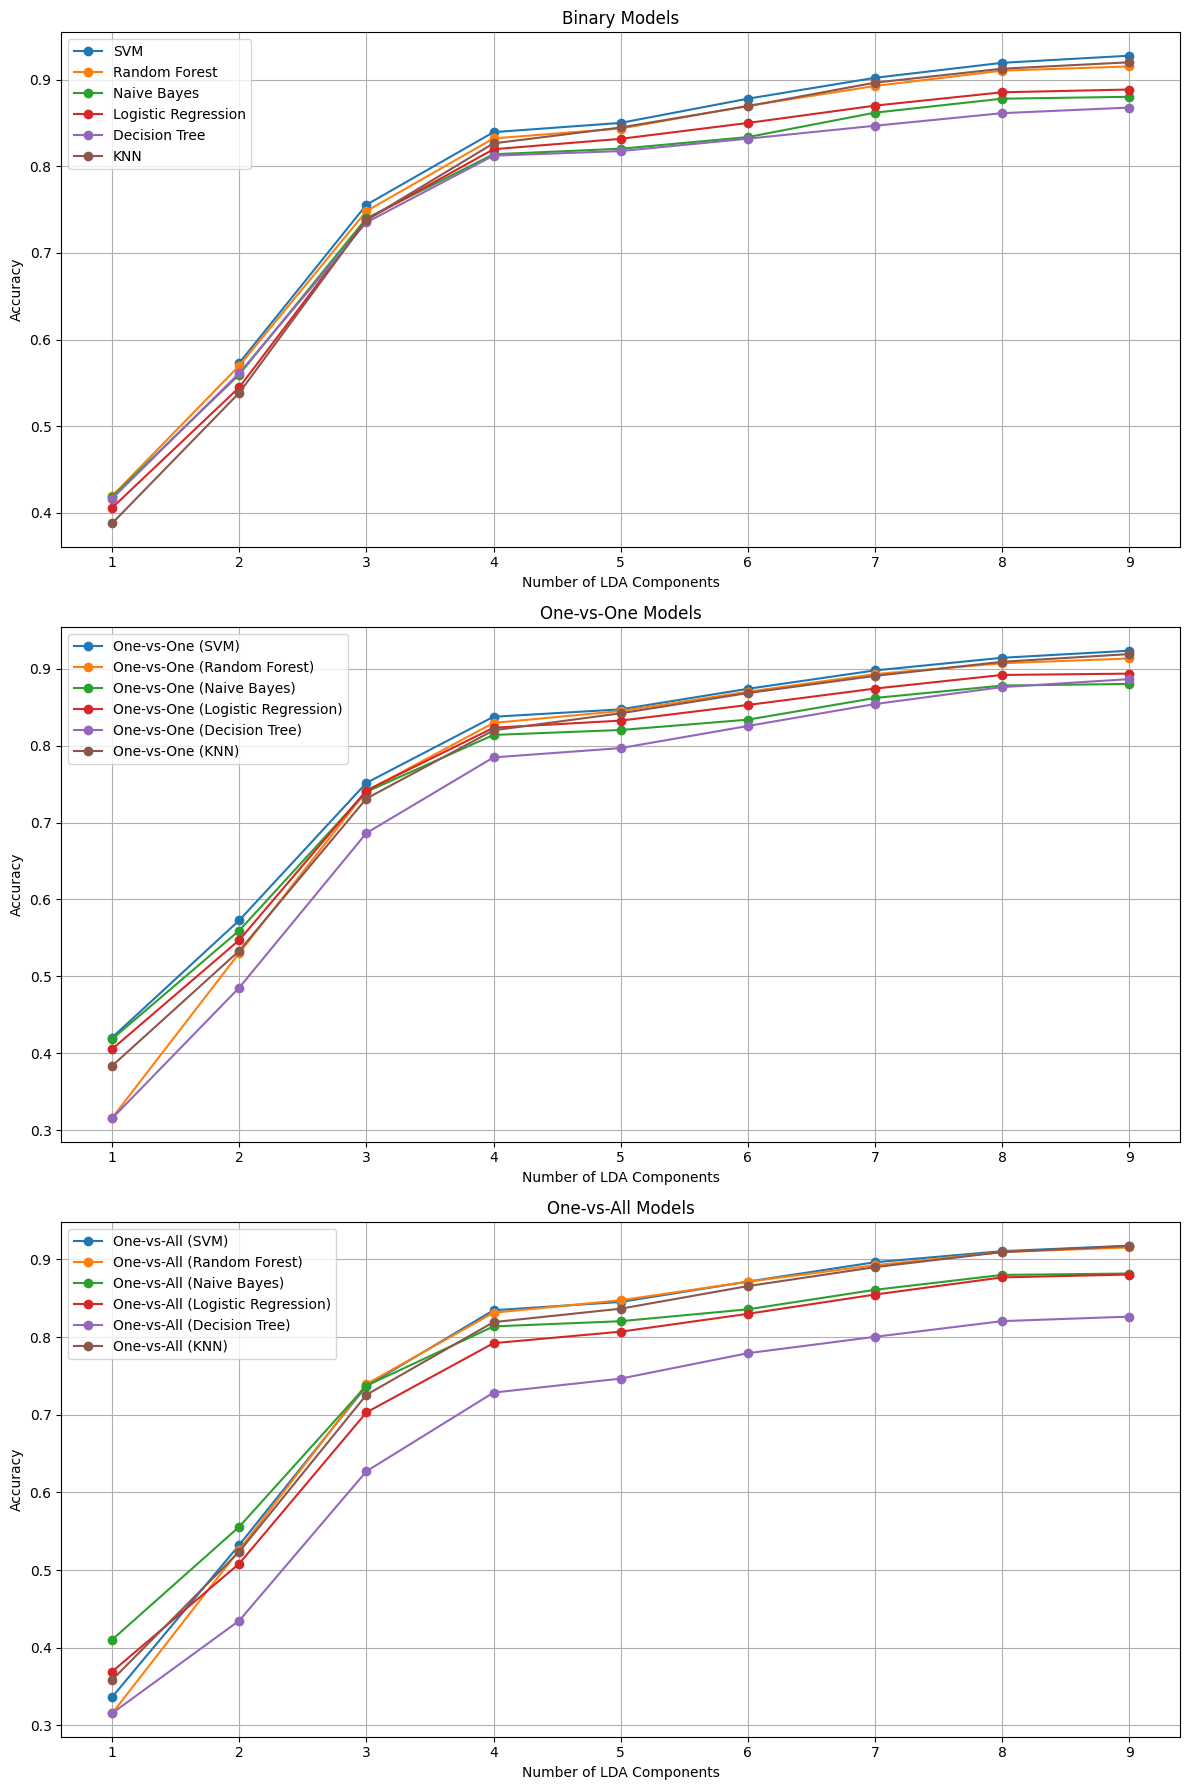

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

def split_models(models):
    binary_models = {name: model for name, model in models.items() if 'One-vs' not in name}
    ova_models = {name: model for name, model in models.items() if 'One-vs-All' in name}
    ovo_models = {name: model for name, model in models.items() if 'One-vs-One' in name}
    return binary_models, ova_models, ovo_models

binary_models, ova_models, ovo_models = split_models(models)

def plot_accuracy_vs_lda_components(models_results, ax, title):
    ax.set_title(title)
    ax.set_xlabel('Number of LDA Components')
    ax.set_ylabel('Accuracy')
    
    for result in models_results:
        ax.plot(range(1, max_lda_components + 1), result['accuracy_list'], marker='o', label=result['model_name'])
    
    ax.legend()  
    ax.grid(True) 

binary_results = [result for result in results if result['model_name'] in binary_models]
plot_accuracy_vs_lda_components(binary_results, axs[0], "Binary Models")

ovo_results = [result for result in results if result['model_name'] in ovo_models]
plot_accuracy_vs_lda_components(ovo_results, axs[1], "One-vs-One Models")

ova_results = [result for result in results if result['model_name'] in ova_models]
plot_accuracy_vs_lda_components(ova_results, axs[2], "One-vs-All Models")

plt.tight_layout()
plt.show()


## For Better visualization 

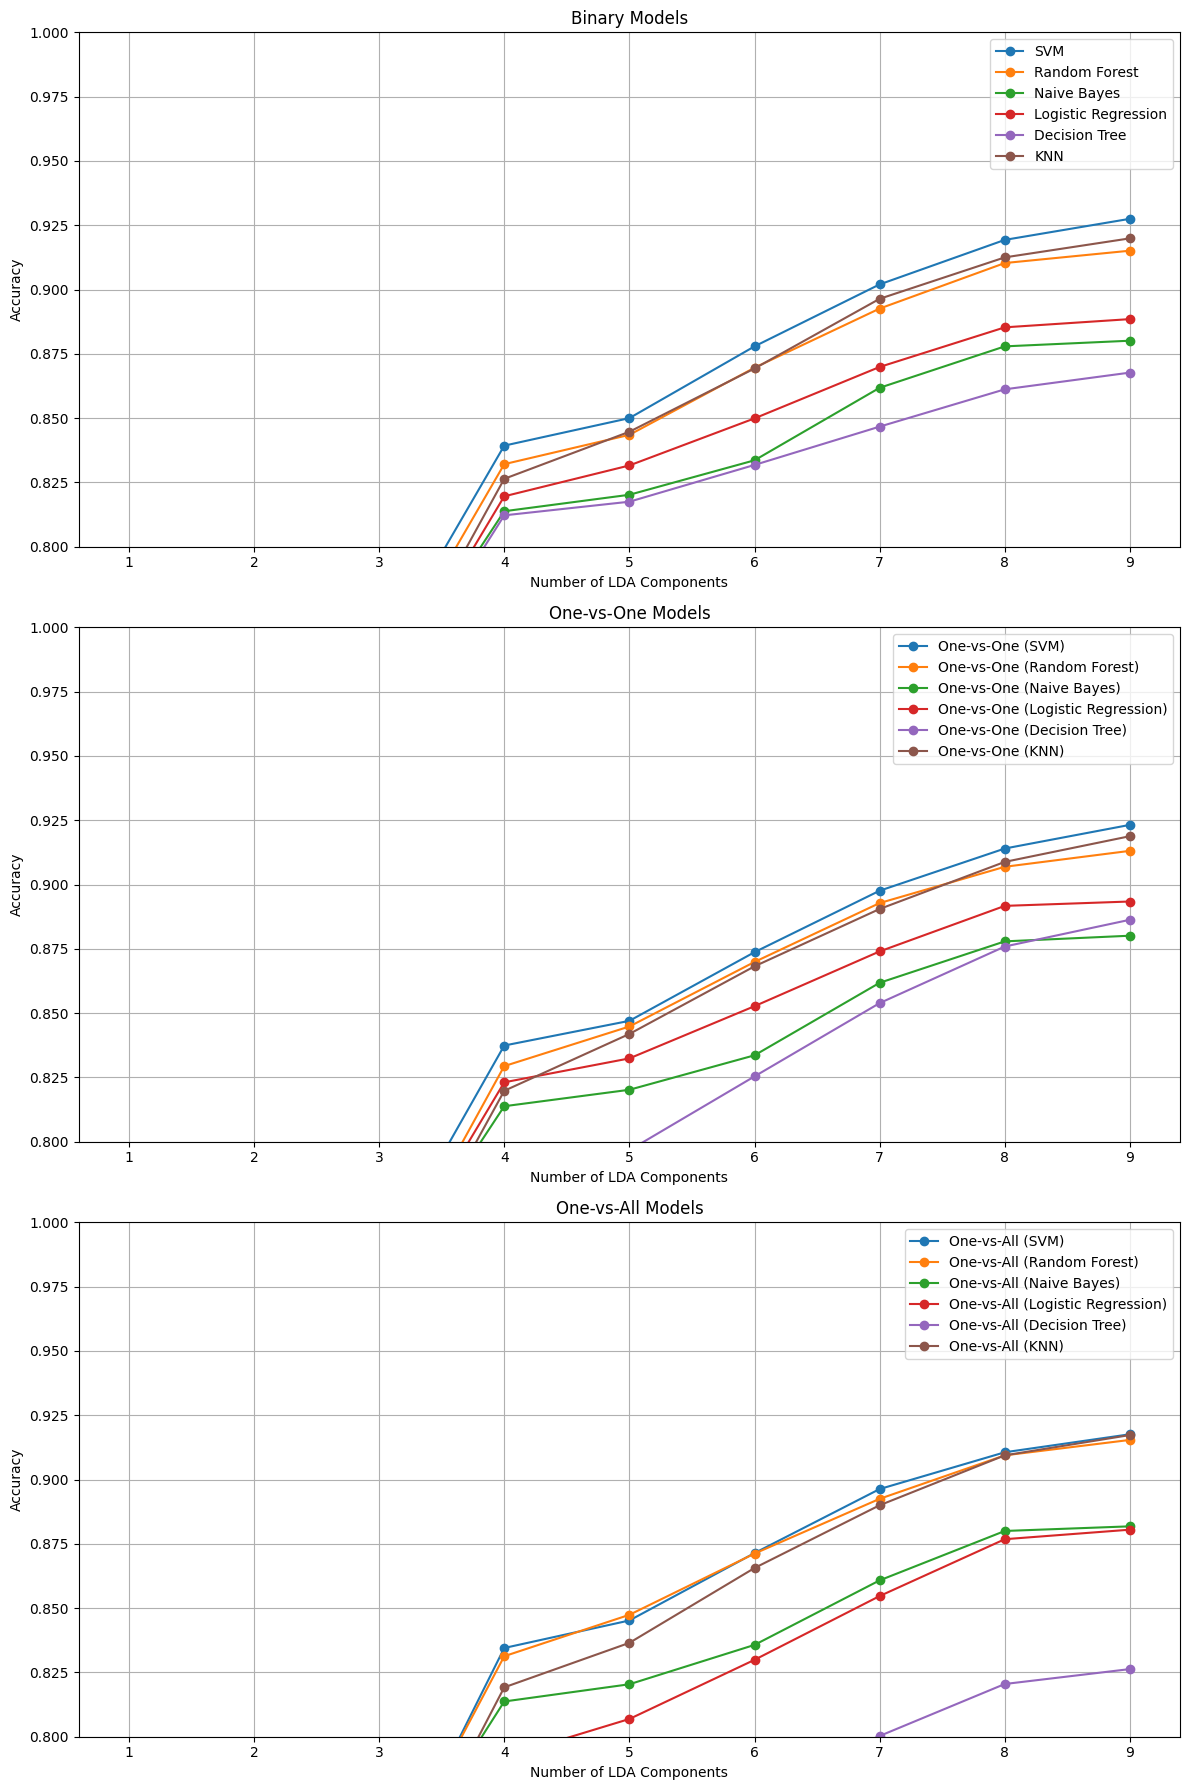

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

def split_models(models):
    binary_models = {name: model for name, model in models.items() if 'One-vs' not in name}
    ova_models = {name: model for name, model in models.items() if 'One-vs-All' in name}
    ovo_models = {name: model for name, model in models.items() if 'One-vs-One' in name}
    return binary_models, ova_models, ovo_models

binary_models, ova_models, ovo_models = split_models(models)

def plot_accuracy_vs_lda_components(models_results, ax, title):
    ax.set_title(title)
    ax.set_xlabel('Number of LDA Components')
    ax.set_ylabel('Accuracy')
    
    for result in models_results:
        ax.plot(range(1, max_lda_components + 1), result['accuracy_list'], marker='o', label=result['model_name'])
    
    # Set y-axis limits to zoom into the range [0.8, 1.0]
    ax.set_ylim(0.8, 1.0)
    
    ax.legend()  
    ax.grid(True)  

binary_results = [result for result in results if result['model_name'] in binary_models]
plot_accuracy_vs_lda_components(binary_results, axs[0], "Binary Models")

ovo_results = [result for result in results if result['model_name'] in ovo_models]
plot_accuracy_vs_lda_components(ovo_results, axs[1], "One-vs-One Models")

ova_results = [result for result in results if result['model_name'] in ova_models]
plot_accuracy_vs_lda_components(ova_results, axs[2], "One-vs-All Models")

plt.tight_layout()
plt.show()


## Comparing the accuracy between binary and Multi class for each model by visualization

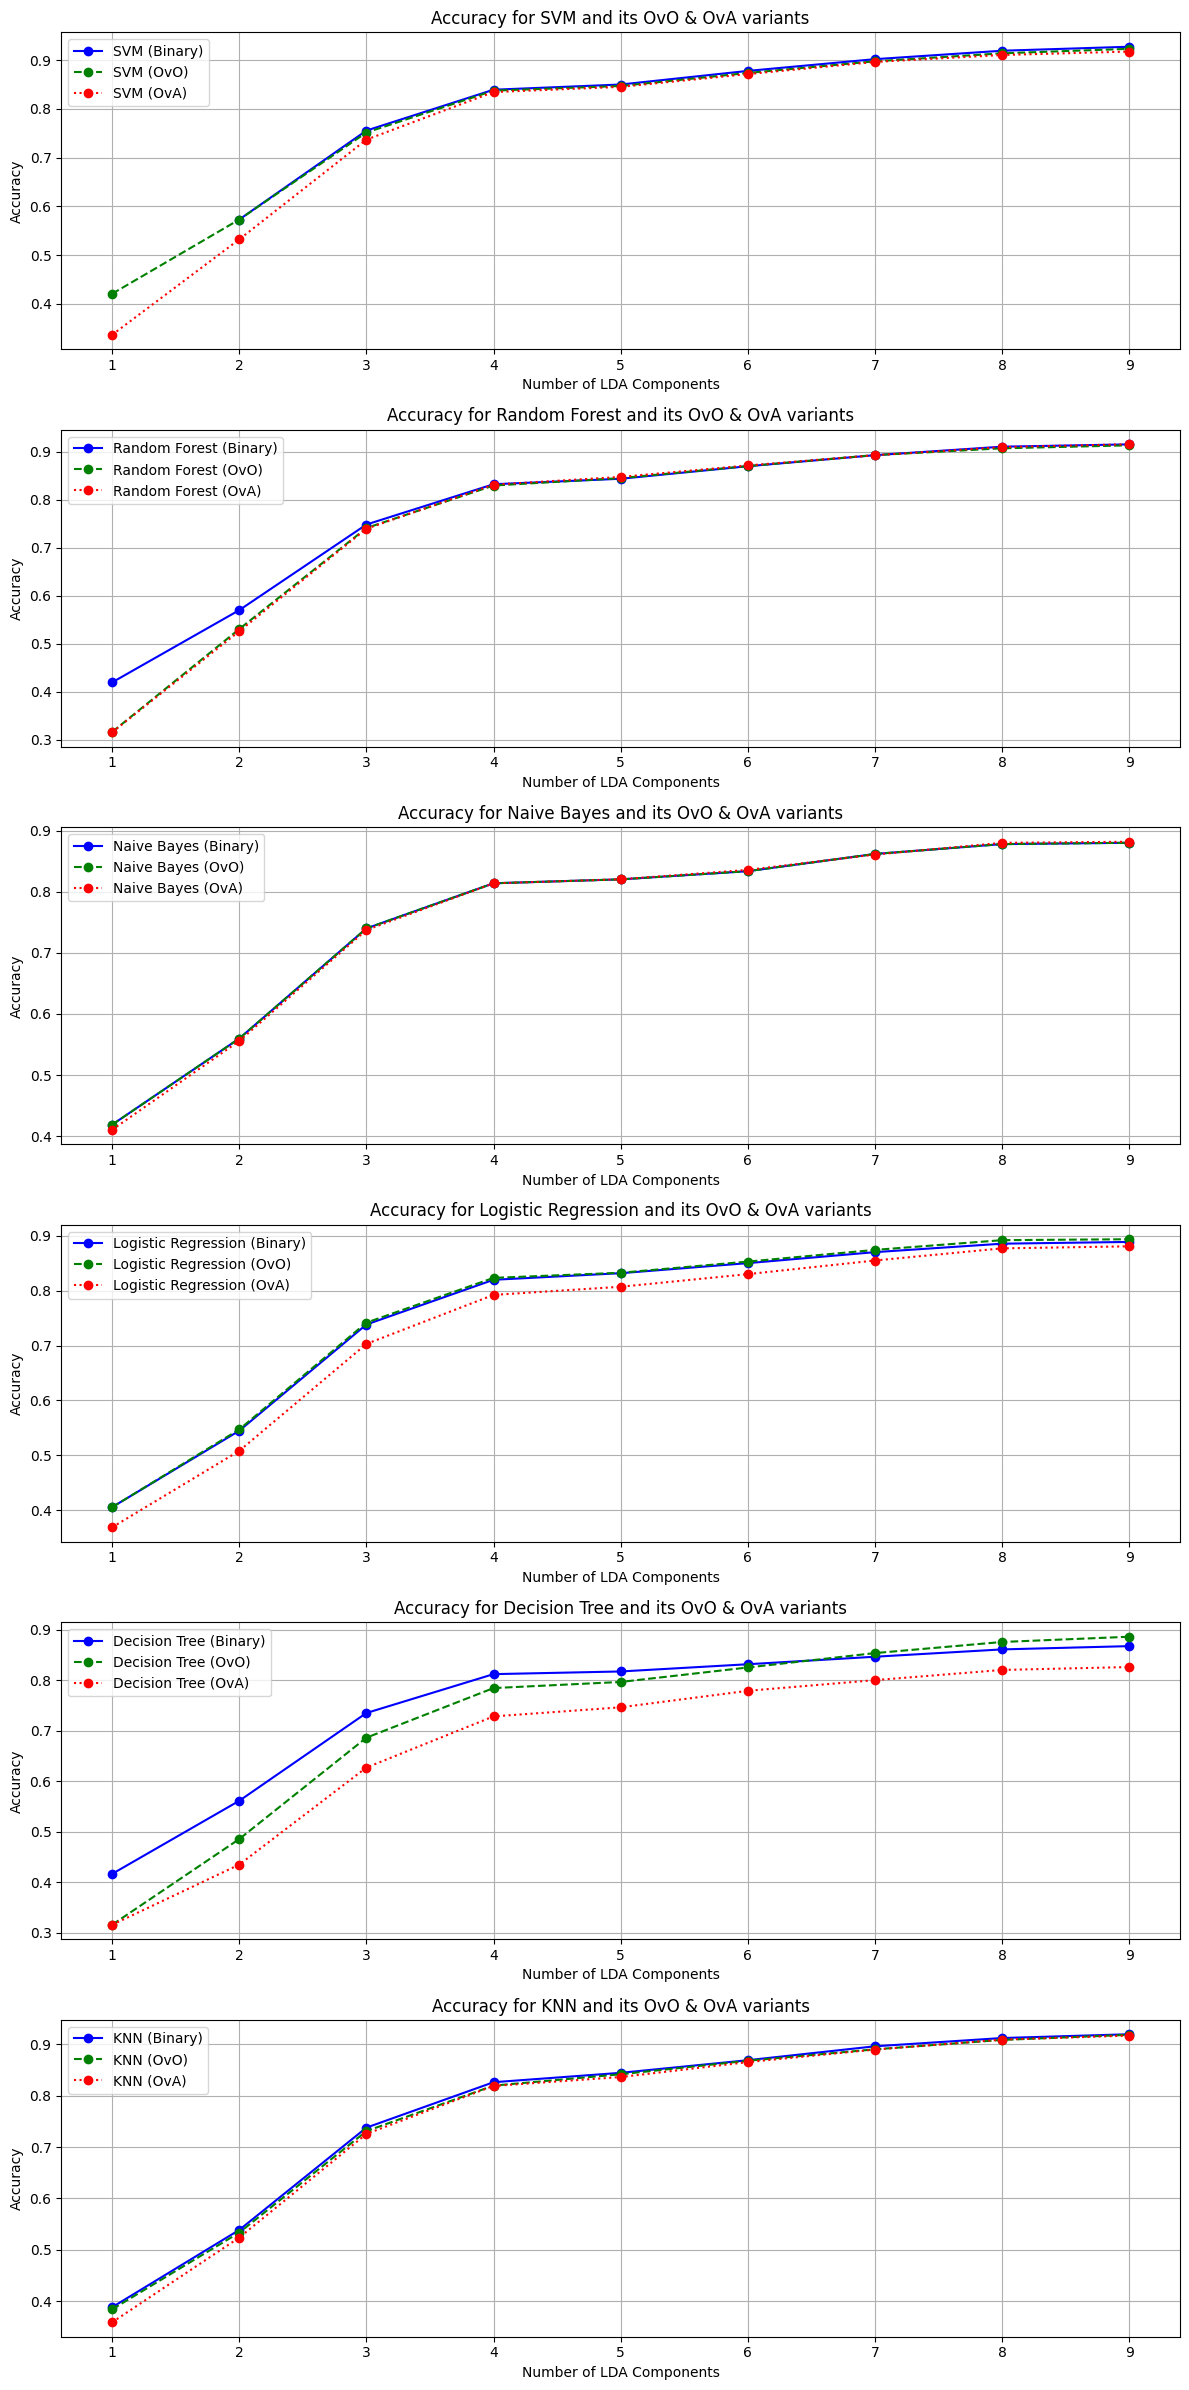

In [36]:
fig, axs = plt.subplots(6, 1, figsize=(12, 24))

def plot_accuracy_vs_lda_for_model(models_results, ax, model_name):
    ax.set_title(f"Accuracy for {model_name} and its OvO & OvA variants")
    ax.set_xlabel('Number of LDA Components')
    ax.set_ylabel('Accuracy')

    binary_model_result = next(result for result in models_results if result['model_name'] == model_name)
    ax.plot(range(1, max_lda_components + 1), binary_model_result['accuracy_list'], marker='o', label=f'{model_name} (Binary)', linestyle='-', color='blue')
    
    ovo_model_result = next(result for result in models_results if result['model_name'] == f'One-vs-One ({model_name})')
    ax.plot(range(1, max_lda_components + 1), ovo_model_result['accuracy_list'], marker='o', label=f'{model_name} (OvO)', linestyle='--', color='green')

    ova_model_result = next(result for result in models_results if result['model_name'] == f'One-vs-All ({model_name})')
    ax.plot(range(1, max_lda_components + 1), ova_model_result['accuracy_list'], marker='o', label=f'{model_name} (OvA)', linestyle=':', color='red')
    
    ax.legend()
    ax.grid(True)

model_names = ['SVM', 'Random Forest', 'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'KNN']

for i, model_name in enumerate(model_names):
    plot_accuracy_vs_lda_for_model(results, axs[i], model_name)

plt.tight_layout()
plt.show()


## Showing the results for binary models

In [32]:
binary_models = {name: model for name, model in models.items() if 'One-vs' not in name}
ova_models = {name: model for name, model in models.items() if 'One-vs-All' in name}
ovo_models = {name: model for name, model in models.items() if 'One-vs-One' in name}

print("\n--- Binary Models ---")
for result in results:
    if result['model_name'] in binary_models:
        print(f"\nBest results for {result['model_name']}:")
        print(f"Highest Accuracy: {result['best_accuracy']:.4f} achieved with {result['best_components']} LDA components")
        print(f"Training Time: {result['training_time']:.2f} seconds")
        print(f"Error Rates per Digit:")
        for digit, error_rate in enumerate(result['error_rates']):
            print(f"  Digit {digit}: {error_rate:.2%}")
        
        if result['model_name'] in param_grids:
            print(f"Best Model Parameters: {result['best_model'].get_params()}")


--- Binary Models ---

Best results for SVM:
Highest Accuracy: 0.9275 achieved with 9 LDA components
Training Time: 29413.47 seconds
Error Rates per Digit:
  Digit 0: 1.84%
  Digit 1: 2.03%
  Digit 2: 7.46%
  Digit 3: 9.31%
  Digit 4: 5.91%
  Digit 5: 11.32%
  Digit 6: 5.11%
  Digit 7: 7.59%
  Digit 8: 12.42%
  Digit 9: 10.51%
Best Model Parameters: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Best results for Random Forest:
Highest Accuracy: 0.9151 achieved with 9 LDA components
Training Time: 5299.30 seconds
Error Rates per Digit:
  Digit 0: 2.14%
  Digit 1: 3.00%
  Digit 2: 9.40%
  Digit 3: 10.20%
  Digit 4: 6.21%
  Digit 5: 14.69%
  Digit 6: 6.16%
  Digit 7: 7.88%
  Digit 8: 14.07%
  Digit 9: 12.39%
Best Model Parameters: {'bootstrap': True, 'ccp_alpha':

## Showing the results for Multi-class models

In [31]:
print("\n--- One-vs-One Models ---")
for result in results:
    if result['model_name'] in ovo_models:
        print(f"\nBest results for {result['model_name']}:")
        print(f"Highest Accuracy: {result['best_accuracy']:.4f} achieved with {result['best_components']} LDA components")
        print(f"Training Time: {result['training_time']:.2f} seconds")
        print(f"Error Rates per Digit:")
        for digit, error_rate in enumerate(result['error_rates']):
            print(f"  Digit {digit}: {error_rate:.2%}")
        
        base_model_name = result['model_name'].split(' (')[0]  # Remove the 'One-vs-One' part
        if base_model_name in param_grids:
            print(f"Best Model Parameters: {result['best_model'].get_params()}")


--- One-vs-One Models ---

Best results for One-vs-One (SVM):
Highest Accuracy: 0.9232 achieved with 9 LDA components
Training Time: 8011.20 seconds
Error Rates per Digit:
  Digit 0: 2.45%
  Digit 1: 2.11%
  Digit 2: 7.36%
  Digit 3: 9.50%
  Digit 4: 6.31%
  Digit 5: 12.11%
  Digit 6: 5.53%
  Digit 7: 8.07%
  Digit 8: 13.14%
  Digit 9: 11.30%

Best results for One-vs-One (Random Forest):
Highest Accuracy: 0.9131 achieved with 9 LDA components
Training Time: 10529.66 seconds
Error Rates per Digit:
  Digit 0: 2.45%
  Digit 1: 3.17%
  Digit 2: 9.21%
  Digit 3: 10.59%
  Digit 4: 6.92%
  Digit 5: 15.92%
  Digit 6: 6.05%
  Digit 7: 8.75%
  Digit 8: 12.83%
  Digit 9: 12.29%

Best results for One-vs-One (Naive Bayes):
Highest Accuracy: 0.8801 achieved with 9 LDA components
Training Time: 912.34 seconds
Error Rates per Digit:
  Digit 0: 4.29%
  Digit 1: 6.78%
  Digit 2: 15.50%
  Digit 3: 13.47%
  Digit 4: 8.76%
  Digit 5: 17.71%
  Digit 6: 8.98%
  Digit 7: 14.11%
  Digit 8: 16.53%
  Digit 9: 1

In [30]:
print("\n--- One-vs-All Models ---")
for result in results:
    if result['model_name'] in ova_models:
        print(f"\nBest results for {result['model_name']}:")
        print(f"Highest Accuracy: {result['best_accuracy']:.4f} achieved with {result['best_components']} LDA components")
        print(f"Training Time: {result['training_time']:.2f} seconds")
        print(f"Error Rates per Digit:")
        for digit, error_rate in enumerate(result['error_rates']):
            print(f"  Digit {digit}: {error_rate:.2%}")
        
        base_model_name = result['model_name'].split(' (')[0]  # Remove the 'One-vs-All' part
        if base_model_name in param_grids:
            print(f"Best Model Parameters: {result['best_model'].get_params()}")



--- One-vs-All Models ---

Best results for One-vs-All (SVM):
Highest Accuracy: 0.9176 achieved with 9 LDA components
Training Time: 8129.87 seconds
Error Rates per Digit:
  Digit 0: 2.24%
  Digit 1: 2.20%
  Digit 2: 9.11%
  Digit 3: 10.79%
  Digit 4: 6.62%
  Digit 5: 12.56%
  Digit 6: 5.11%
  Digit 7: 8.27%
  Digit 8: 14.68%
  Digit 9: 11.89%

Best results for One-vs-All (Random Forest):
Highest Accuracy: 0.9154 achieved with 9 LDA components
Training Time: 7596.70 seconds
Error Rates per Digit:
  Digit 0: 2.45%
  Digit 1: 2.64%
  Digit 2: 9.11%
  Digit 3: 11.19%
  Digit 4: 6.72%
  Digit 5: 14.69%
  Digit 6: 5.53%
  Digit 7: 8.46%
  Digit 8: 12.83%
  Digit 9: 12.19%

Best results for One-vs-All (Naive Bayes):
Highest Accuracy: 0.8818 achieved with 9 LDA components
Training Time: 878.30 seconds
Error Rates per Digit:
  Digit 0: 4.18%
  Digit 1: 5.46%
  Digit 2: 16.18%
  Digit 3: 13.27%
  Digit 4: 8.96%
  Digit 5: 18.72%
  Digit 6: 8.66%
  Digit 7: 13.62%
  Digit 8: 15.81%
  Digit 9: 1

## Plotting the error for each digit for every model

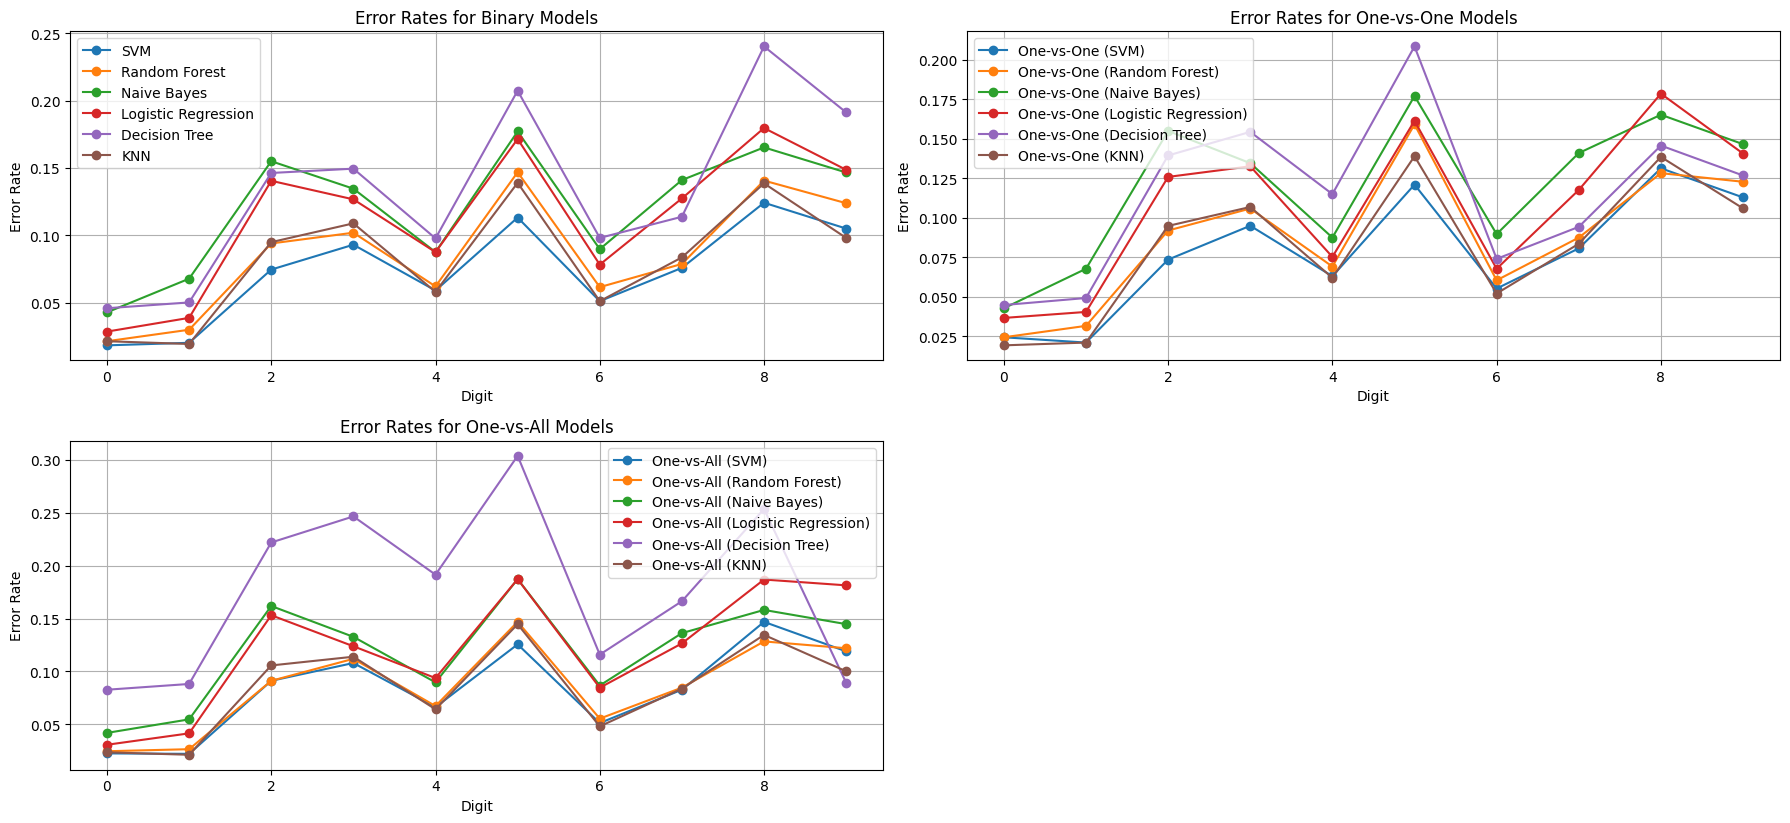

In [34]:
binary_models = {name: model for name, model in models.items() if 'One-vs' not in name}
ova_models = {name: model for name, model in models.items() if 'One-vs-All' in name}
ovo_models = {name: model for name, model in models.items() if 'One-vs-One' in name}

plt.figure(figsize=(18, 12))

plt.subplot(3, 2, 1)
for result in results:
    if result['model_name'] in binary_models:
        plt.plot(range(10), result['error_rates'], marker='o', label=result['model_name'])
plt.title('Error Rates for Binary Models')
plt.xlabel('Digit')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
for result in results:
    if result['model_name'] in ovo_models:
        plt.plot(range(10), result['error_rates'], marker='o', label=result['model_name'])
plt.title('Error Rates for One-vs-One Models')
plt.xlabel('Digit')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
for result in results:
    if result['model_name'] in ova_models:
        plt.plot(range(10), result['error_rates'], marker='o', label=result['model_name'])
plt.title('Error Rates for One-vs-All Models')
plt.xlabel('Digit')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()


## Classification Report and Confusion Matrix

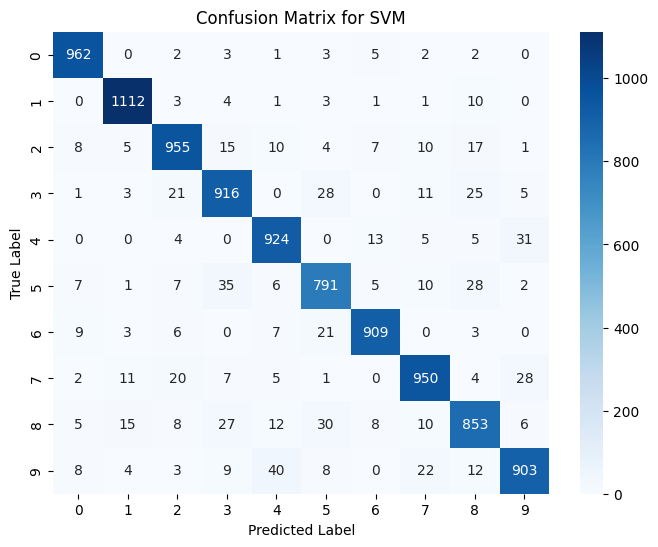

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.93      0.93      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.94      0.93       982
           5       0.89      0.89      0.89       892
           6       0.96      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.89      0.88      0.88       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



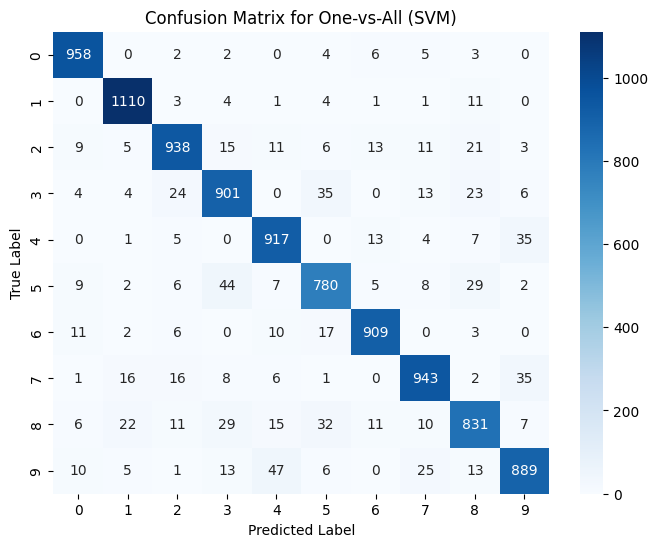

Classification Report for One-vs-All (SVM):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.93      0.91      0.92      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.93      0.92       982
           5       0.88      0.87      0.88       892
           6       0.95      0.95      0.95       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.91      0.88      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



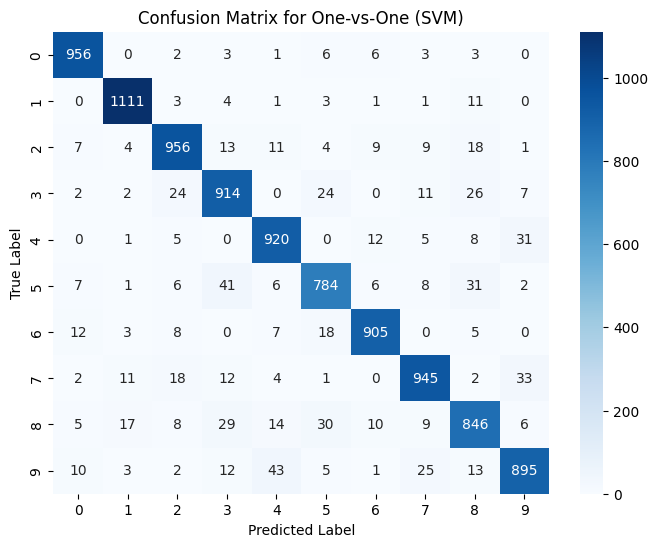

Classification Report for One-vs-One (SVM):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.93      0.93      1032
           3       0.89      0.90      0.90      1010
           4       0.91      0.94      0.93       982
           5       0.90      0.88      0.89       892
           6       0.95      0.94      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.87      0.87       974
           9       0.92      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



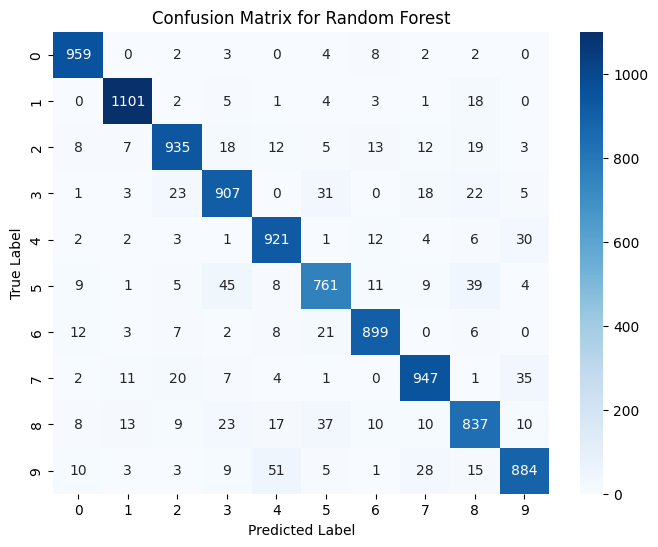

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.93      0.91      0.92      1032
           3       0.89      0.90      0.89      1010
           4       0.90      0.94      0.92       982
           5       0.87      0.85      0.86       892
           6       0.94      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.86      0.86       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



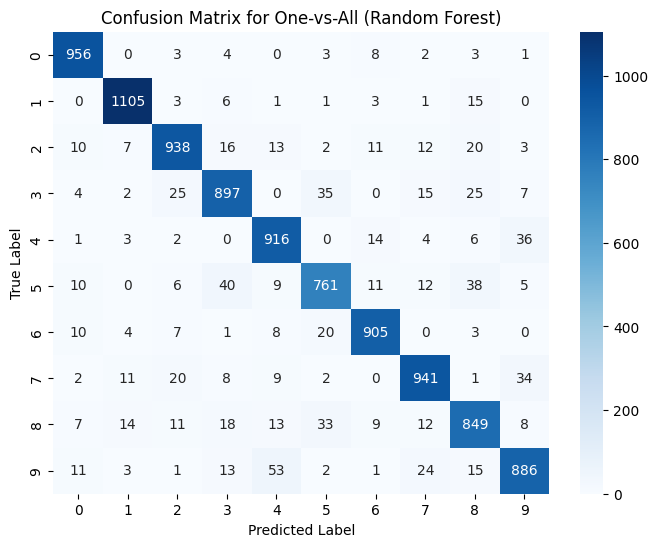

Classification Report for One-vs-All (Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.93      0.91       982
           5       0.89      0.85      0.87       892
           6       0.94      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



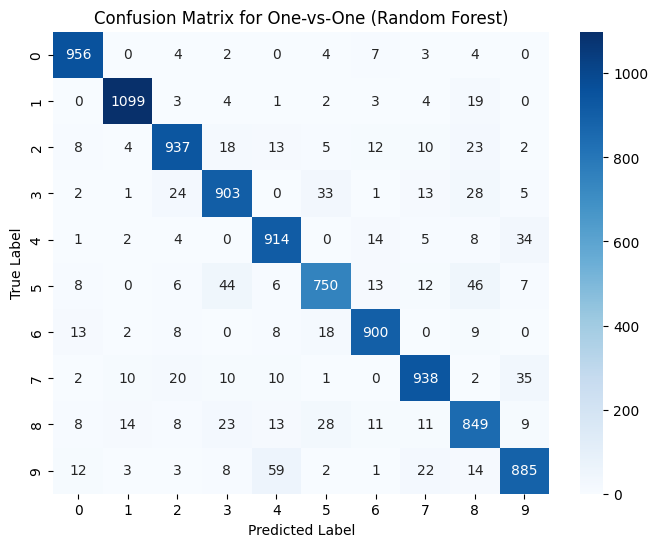

Classification Report for One-vs-One (Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.92      0.91      0.91      1032
           3       0.89      0.89      0.89      1010
           4       0.89      0.93      0.91       982
           5       0.89      0.84      0.86       892
           6       0.94      0.94      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.85      0.87      0.86       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



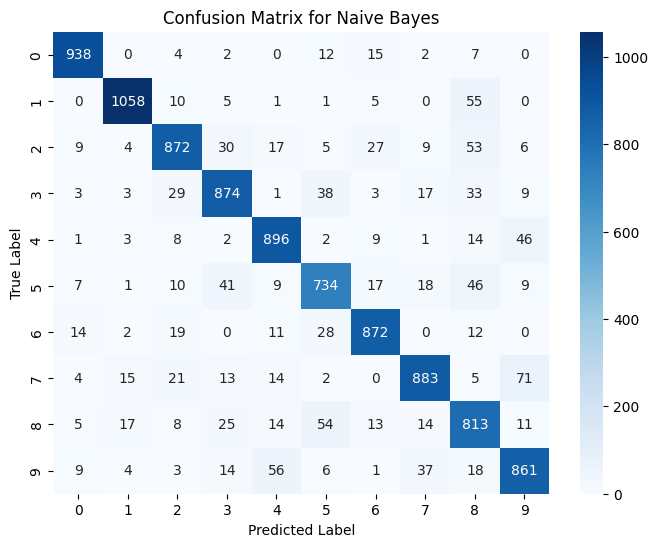

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.96      0.93      0.94      1135
           2       0.89      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



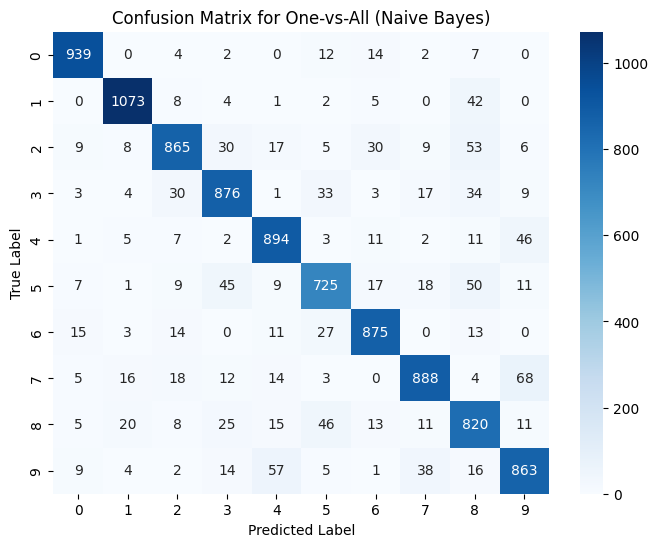

Classification Report for One-vs-All (Naive Bayes):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.95      0.95      0.95      1135
           2       0.90      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.89       982
           5       0.84      0.81      0.83       892
           6       0.90      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.78      0.84      0.81       974
           9       0.85      0.86      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



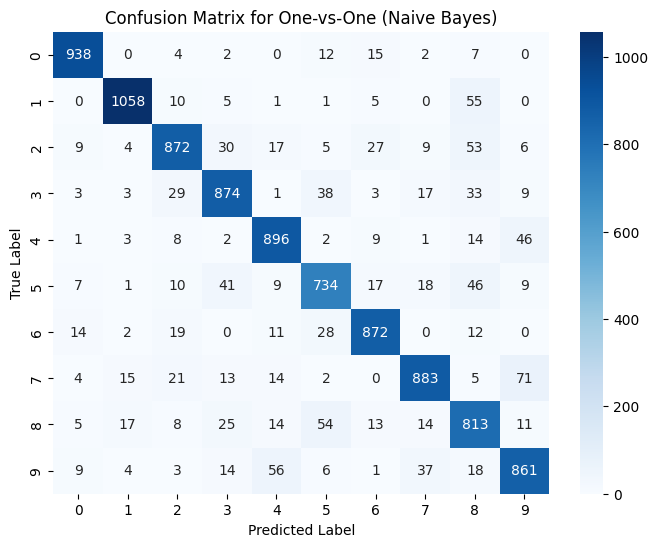

Classification Report for One-vs-One (Naive Bayes):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.96      0.93      0.94      1135
           2       0.89      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



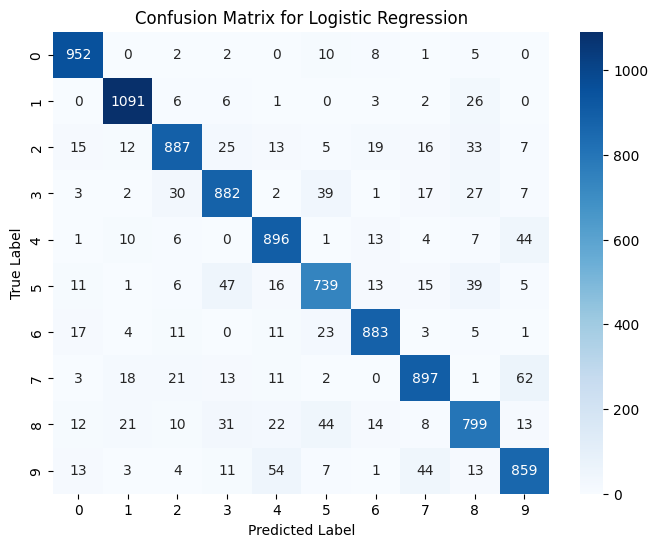

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.96      0.95      1135
           2       0.90      0.86      0.88      1032
           3       0.87      0.87      0.87      1010
           4       0.87      0.91      0.89       982
           5       0.85      0.83      0.84       892
           6       0.92      0.92      0.92       958
           7       0.89      0.87      0.88      1028
           8       0.84      0.82      0.83       974
           9       0.86      0.85      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



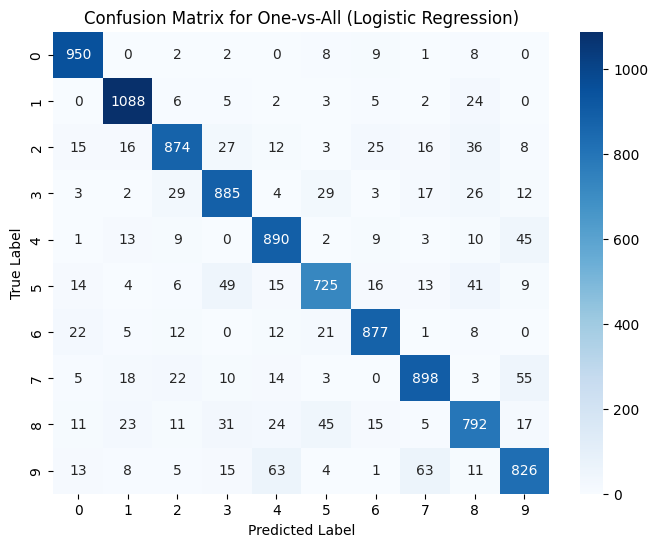

Classification Report for One-vs-All (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.92      0.96      0.94      1135
           2       0.90      0.85      0.87      1032
           3       0.86      0.88      0.87      1010
           4       0.86      0.91      0.88       982
           5       0.86      0.81      0.84       892
           6       0.91      0.92      0.91       958
           7       0.88      0.87      0.88      1028
           8       0.83      0.81      0.82       974
           9       0.85      0.82      0.83      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



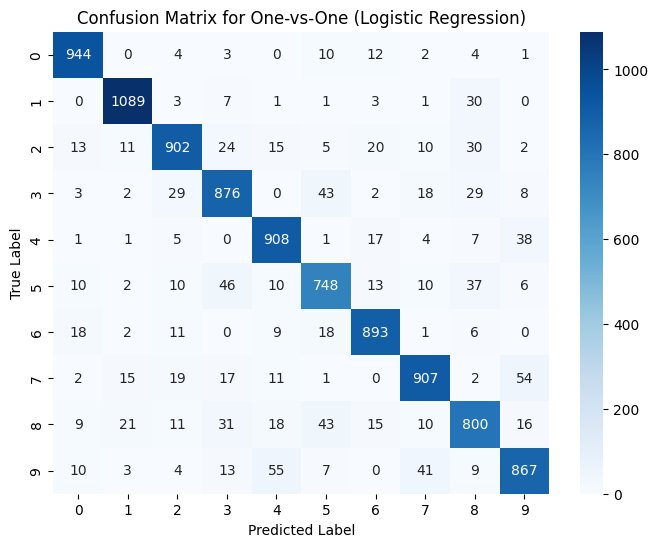

Classification Report for One-vs-One (Logistic Regression):
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       980
           1       0.95      0.96      0.95      1135
           2       0.90      0.87      0.89      1032
           3       0.86      0.87      0.86      1010
           4       0.88      0.92      0.90       982
           5       0.85      0.84      0.85       892
           6       0.92      0.93      0.92       958
           7       0.90      0.88      0.89      1028
           8       0.84      0.82      0.83       974
           9       0.87      0.86      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



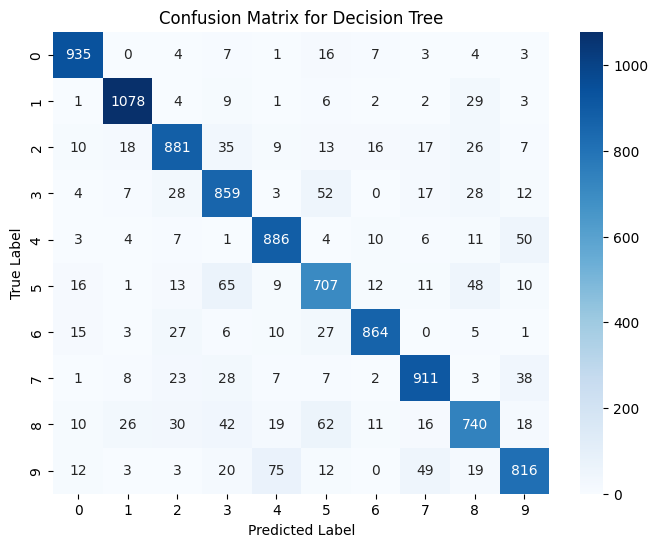

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.94      0.95      0.94      1135
           2       0.86      0.85      0.86      1032
           3       0.80      0.85      0.83      1010
           4       0.87      0.90      0.89       982
           5       0.78      0.79      0.79       892
           6       0.94      0.90      0.92       958
           7       0.88      0.89      0.88      1028
           8       0.81      0.76      0.78       974
           9       0.85      0.81      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



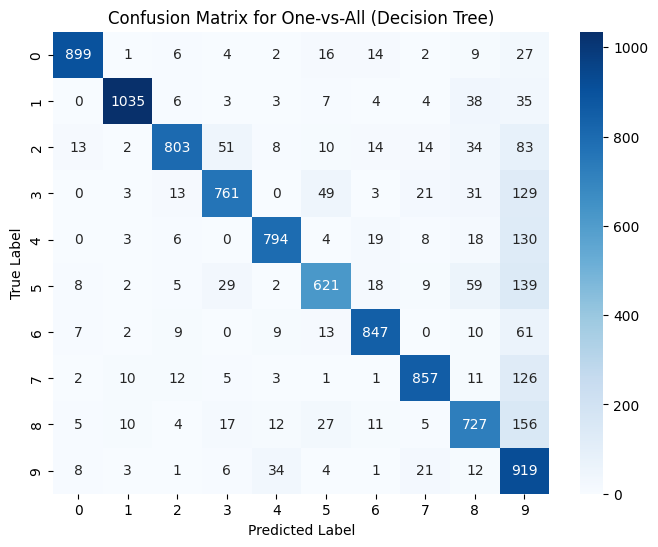

Classification Report for One-vs-All (Decision Tree):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       980
           1       0.97      0.91      0.94      1135
           2       0.93      0.78      0.85      1032
           3       0.87      0.75      0.81      1010
           4       0.92      0.81      0.86       982
           5       0.83      0.70      0.76       892
           6       0.91      0.88      0.90       958
           7       0.91      0.83      0.87      1028
           8       0.77      0.75      0.76       974
           9       0.51      0.91      0.65      1009

    accuracy                           0.83     10000
   macro avg       0.86      0.82      0.83     10000
weighted avg       0.86      0.83      0.83     10000



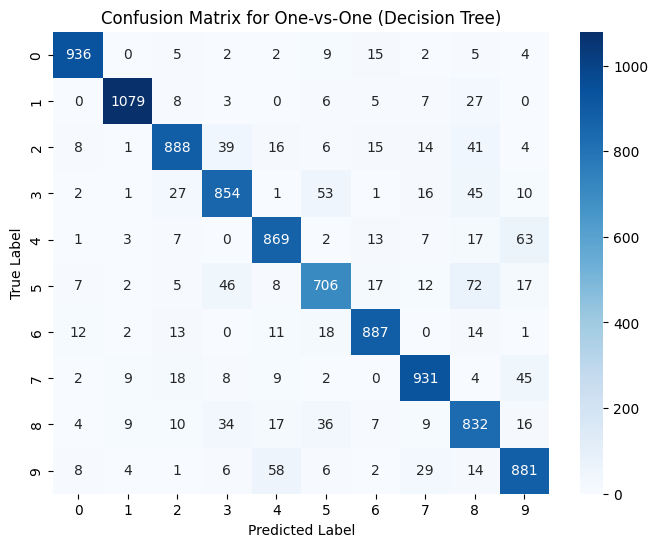

Classification Report for One-vs-One (Decision Tree):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.97      0.95      0.96      1135
           2       0.90      0.86      0.88      1032
           3       0.86      0.85      0.85      1010
           4       0.88      0.88      0.88       982
           5       0.84      0.79      0.81       892
           6       0.92      0.93      0.92       958
           7       0.91      0.91      0.91      1028
           8       0.78      0.85      0.81       974
           9       0.85      0.87      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000



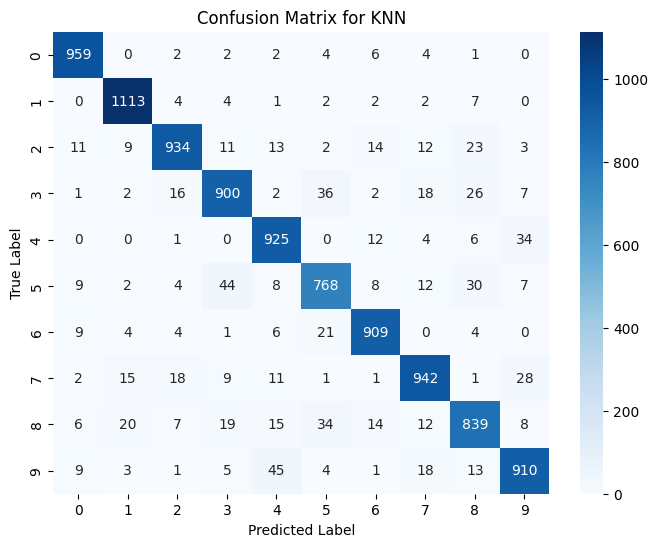

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.95      0.98      0.97      1135
           2       0.94      0.91      0.92      1032
           3       0.90      0.89      0.90      1010
           4       0.90      0.94      0.92       982
           5       0.88      0.86      0.87       892
           6       0.94      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



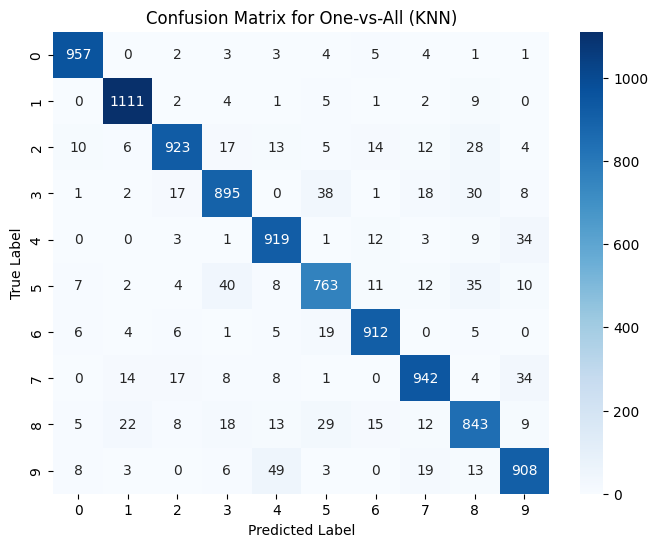

Classification Report for One-vs-All (KNN):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.95      0.98      0.97      1135
           2       0.94      0.89      0.92      1032
           3       0.90      0.89      0.89      1010
           4       0.90      0.94      0.92       982
           5       0.88      0.86      0.87       892
           6       0.94      0.95      0.95       958
           7       0.92      0.92      0.92      1028
           8       0.86      0.87      0.86       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



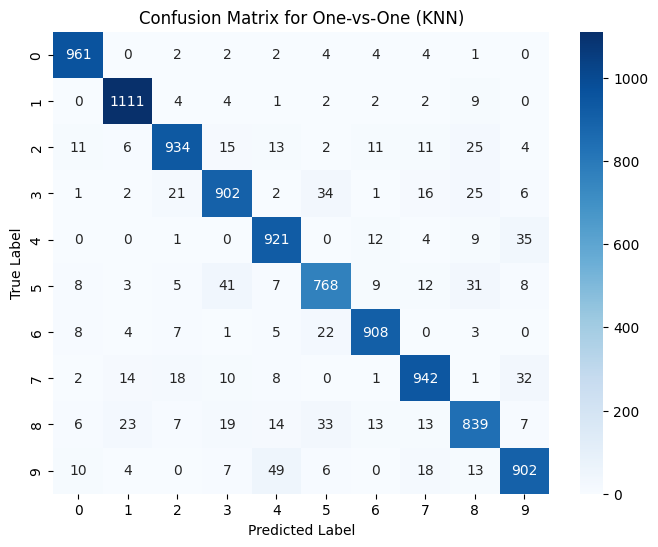

Classification Report for One-vs-One (KNN):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.95      0.98      0.97      1135
           2       0.93      0.91      0.92      1032
           3       0.90      0.89      0.90      1010
           4       0.90      0.94      0.92       982
           5       0.88      0.86      0.87       892
           6       0.94      0.95      0.95       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [41]:
def evaluate_model_with_metrics(model, X_train, y_train, X_test, y_test, name):
    lda = LDA(n_components=9) # as we know that the highest accuracy came at 9 components
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    model.fit(X_train_lda, y_train)
    y_pred = model.predict(X_test_lda)
    
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    return clf_report, cm

def calculate_metrics_for_all_models(models, X_train_scaled, y_train, X_test_scaled, y_test, results):
    for result in results:
        if result['model_name'] in models:
            model = result['best_model']
            model_name = result['model_name']
            
            clf_report, cm = evaluate_model_with_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test, model_name)
            
            result['classification_report'] = clf_report
            result['confusion_matrix'] = cm
            
calculate_metrics_for_all_models(models, X_train_scaled, y_train, X_test_scaled, y_test, results)


## Saving the results in a csv file

In [37]:
def save_results_to_csv(results, filename="model_results.csv"):
    results_list = []
    
    for result in results:
        model_info = {
            'model_name': result['model_name'],
            'best_accuracy': result['best_accuracy'],
            'best_components': result['best_components'],
            'training_time': result['training_time'],
        }
        
        for digit, error_rate in enumerate(result['error_rates']):
            model_info[f'error_rate_digit_{digit}'] = error_rate
        
        if hasattr(result['best_model'], 'get_params'):
            params = result['best_model'].get_params()
            for param_name, param_value in params.items():
                model_info[f'param_{param_name}'] = param_value
        
        results_list.append(model_info)
    
    df = pd.DataFrame(results_list)
    
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

save_results_to_csv(results, "model_results.csv")


Results saved to model_results.csv


## Ensemble learning(Bagging) 

Bagging model accuracy for SVM: 0.9268
Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.93      0.93      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.94      0.93       982
           5       0.89      0.89      0.89       892
           6       0.96      0.94      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.89      0.87      0.88       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



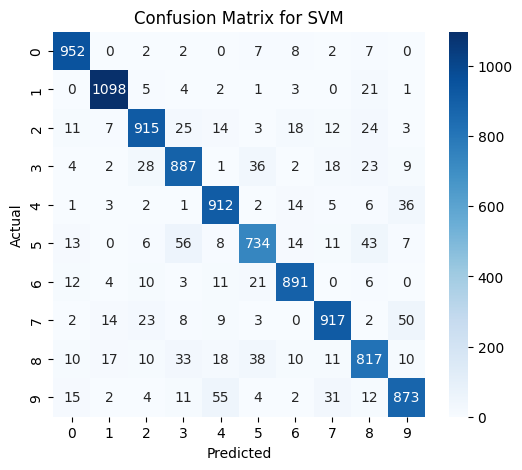

Bagging model accuracy for One-vs-All (SVM): 0.9187
Classification Report for One-vs-All (SVM):

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.93      0.92      0.92      1032
           3       0.89      0.90      0.89      1010
           4       0.90      0.93      0.92       982
           5       0.88      0.88      0.88       892
           6       0.95      0.95      0.95       958
           7       0.92      0.92      0.92      1028
           8       0.89      0.85      0.87       974
           9       0.91      0.88      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



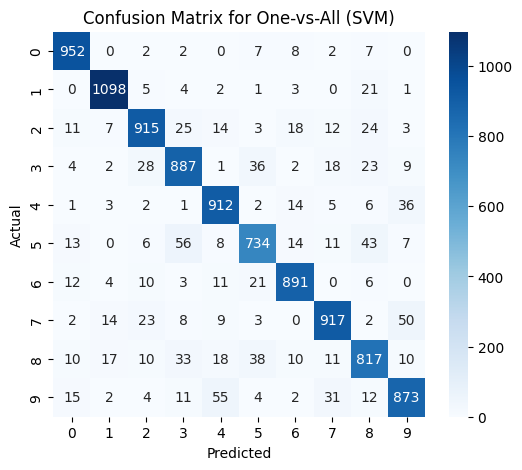

Bagging model accuracy for One-vs-One (SVM): 0.9228
Classification Report for One-vs-One (SVM):

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.93      0.92      1032
           3       0.89      0.90      0.90      1010
           4       0.91      0.94      0.93       982
           5       0.90      0.88      0.89       892
           6       0.95      0.94      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.87      0.87       974
           9       0.92      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



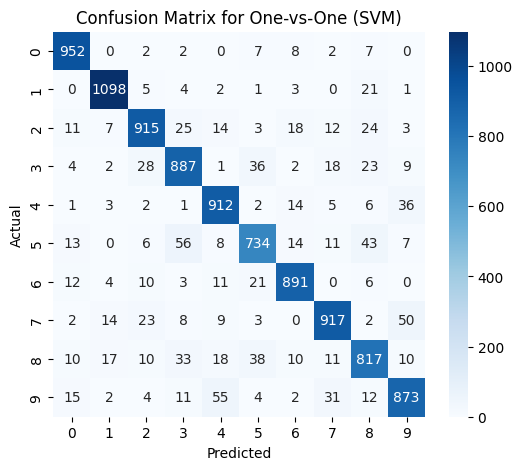

Bagging model accuracy for Random Forest: 0.9146
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.94      0.92       982
           5       0.88      0.86      0.87       892
           6       0.94      0.94      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.87      0.86      0.87       974
           9       0.90      0.87      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



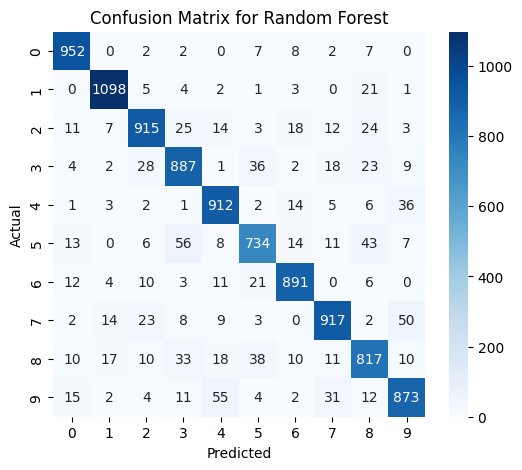

Bagging model accuracy for One-vs-All (Random Forest): 0.9149
Classification Report for One-vs-All (Random Forest):

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.94      0.92       982
           5       0.89      0.85      0.87       892
           6       0.94      0.95      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



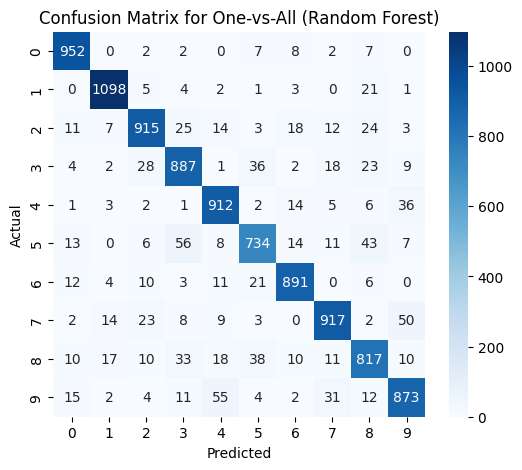

Bagging model accuracy for One-vs-One (Random Forest): 0.9139
Classification Report for One-vs-One (Random Forest):

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.92      0.91      0.91      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.93      0.91       982
           5       0.89      0.85      0.87       892
           6       0.93      0.94      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.86      0.87      0.86       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



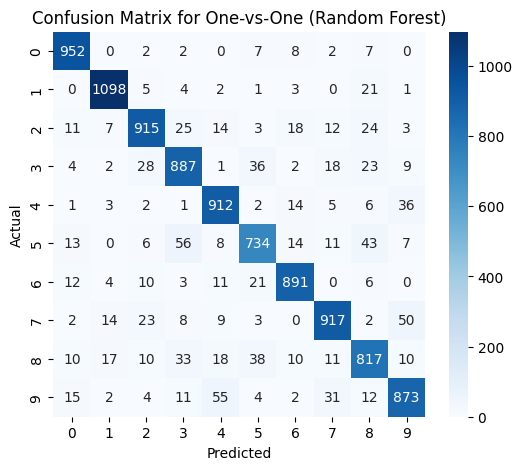

Bagging model accuracy for Naive Bayes: 0.8800
Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.96      0.93      0.94      1135
           2       0.89      0.84      0.86      1032
           3       0.87      0.86      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.86      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



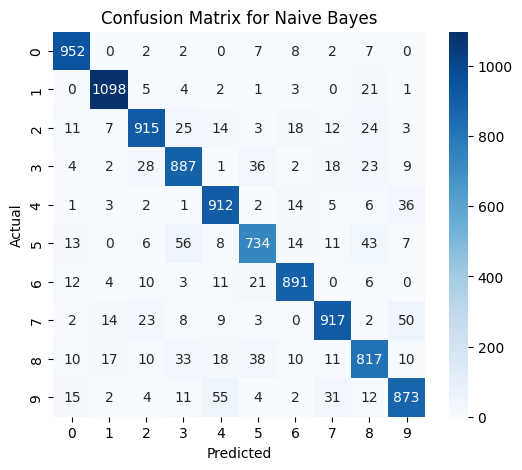

Bagging model accuracy for One-vs-All (Naive Bayes): 0.8814
Classification Report for One-vs-All (Naive Bayes):

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.95      0.95      0.95      1135
           2       0.89      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.89       982
           5       0.84      0.81      0.83       892
           6       0.90      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.78      0.84      0.81       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



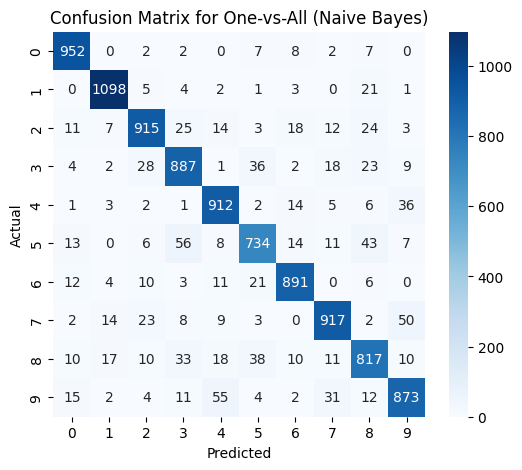

Bagging model accuracy for One-vs-One (Naive Bayes): 0.8798
Classification Report for One-vs-One (Naive Bayes):

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.95      0.93      0.94      1135
           2       0.88      0.84      0.86      1032
           3       0.87      0.86      0.87      1010
           4       0.88      0.91      0.89       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



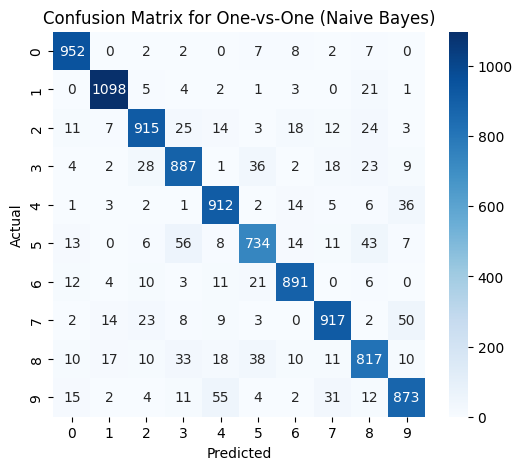

Bagging model accuracy for Logistic Regression: 0.8889
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.96      0.95      1135
           2       0.90      0.86      0.88      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.89       982
           5       0.85      0.83      0.84       892
           6       0.92      0.92      0.92       958
           7       0.89      0.88      0.88      1028
           8       0.84      0.82      0.83       974
           9       0.86      0.85      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



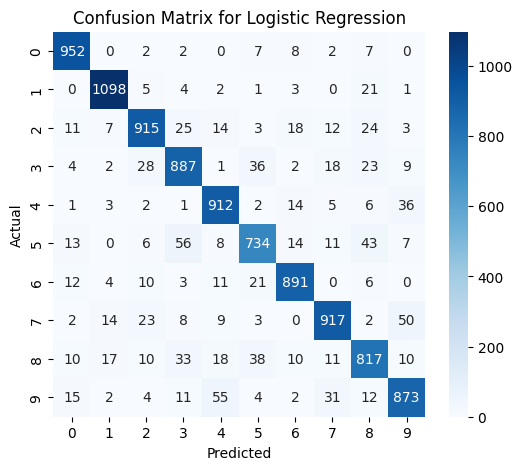

Bagging model accuracy for One-vs-All (Logistic Regression): 0.8803
Classification Report for One-vs-All (Logistic Regression):

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.92      0.96      0.94      1135
           2       0.90      0.84      0.87      1032
           3       0.86      0.88      0.87      1010
           4       0.86      0.91      0.88       982
           5       0.86      0.82      0.84       892
           6       0.91      0.91      0.91       958
           7       0.88      0.87      0.88      1028
           8       0.83      0.81      0.82       974
           9       0.85      0.82      0.83      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



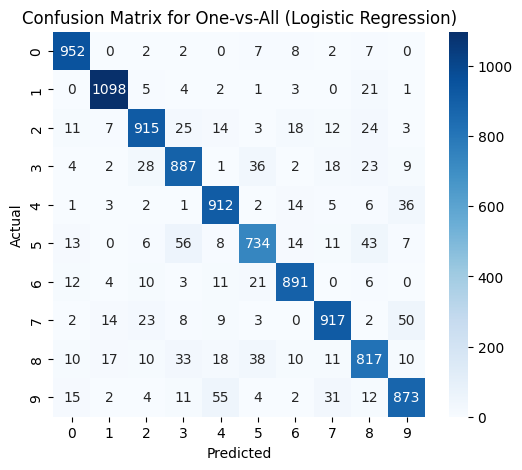

Bagging model accuracy for One-vs-One (Logistic Regression): 0.8936
Classification Report for One-vs-One (Logistic Regression):

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       980
           1       0.95      0.96      0.96      1135
           2       0.91      0.87      0.89      1032
           3       0.86      0.87      0.87      1010
           4       0.88      0.93      0.91       982
           5       0.85      0.84      0.85       892
           6       0.92      0.93      0.92       958
           7       0.90      0.88      0.89      1028
           8       0.84      0.82      0.83       974
           9       0.88      0.86      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



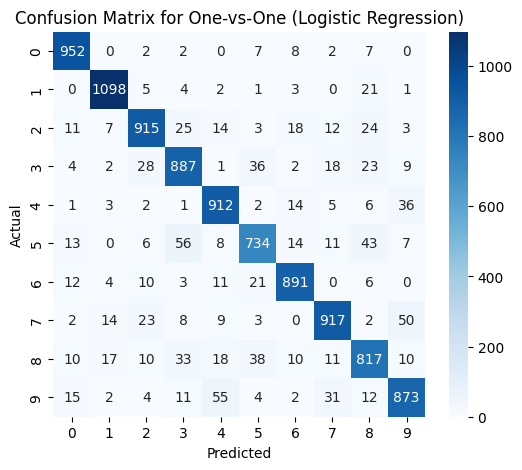

Bagging model accuracy for Decision Tree: 0.8987
Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       0.96      0.96      0.96      1135
           2       0.91      0.88      0.90      1032
           3       0.87      0.88      0.88      1010
           4       0.89      0.92      0.91       982
           5       0.85      0.83      0.84       892
           6       0.93      0.93      0.93       958
           7       0.91      0.90      0.90      1028
           8       0.83      0.83      0.83       974
           9       0.89      0.86      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



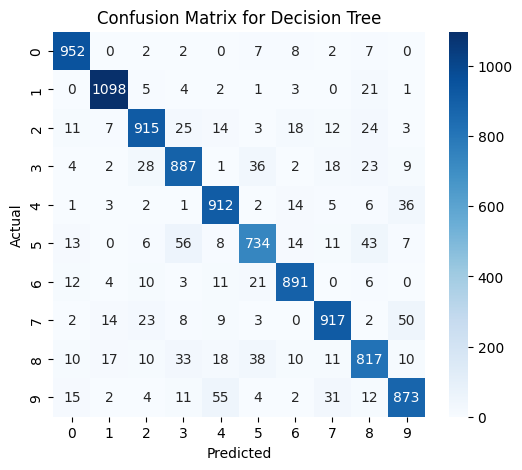

Bagging model accuracy for One-vs-All (Decision Tree): 0.6811
Classification Report for One-vs-All (Decision Tree):

              precision    recall  f1-score   support

           0       0.24      1.00      0.39       980
           1       1.00      0.84      0.91      1135
           2       0.98      0.63      0.77      1032
           3       0.98      0.59      0.74      1010
           4       0.98      0.67      0.79       982
           5       0.96      0.49      0.65       892
           6       0.98      0.76      0.85       958
           7       0.98      0.73      0.84      1028
           8       0.98      0.49      0.66       974
           9       0.97      0.57      0.72      1009

    accuracy                           0.68     10000
   macro avg       0.91      0.68      0.73     10000
weighted avg       0.91      0.68      0.74     10000



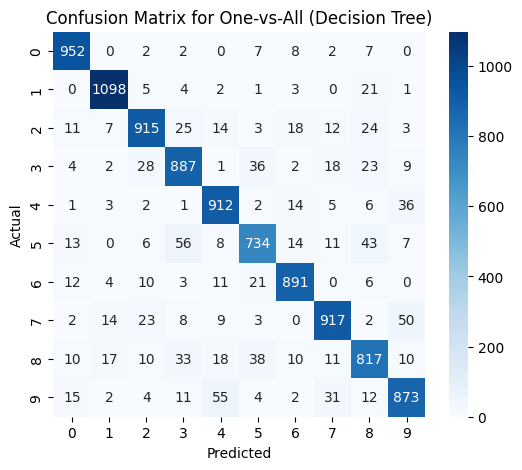

Bagging model accuracy for One-vs-One (Decision Tree): 0.9067
Classification Report for One-vs-One (Decision Tree):

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.96      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.89      0.88      0.88      1010
           4       0.89      0.93      0.91       982
           5       0.88      0.84      0.86       892
           6       0.93      0.94      0.93       958
           7       0.92      0.90      0.91      1028
           8       0.82      0.86      0.84       974
           9       0.88      0.88      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



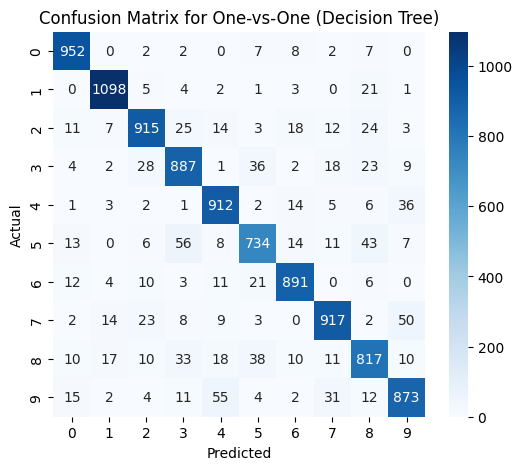

Bagging model accuracy for KNN: 0.9200
Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.95      0.98      0.97      1135
           2       0.94      0.91      0.92      1032
           3       0.91      0.89      0.90      1010
           4       0.90      0.94      0.92       982
           5       0.89      0.86      0.87       892
           6       0.94      0.95      0.95       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



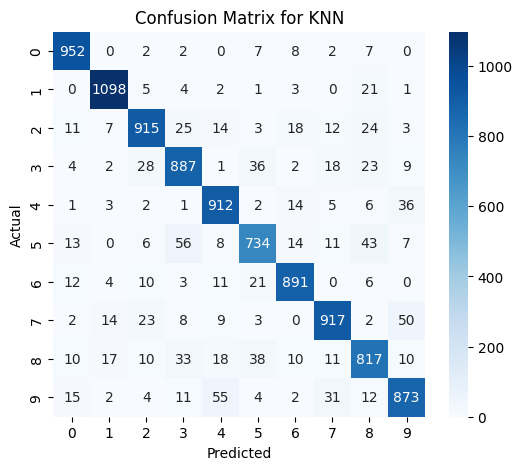

Bagging model accuracy for One-vs-All (KNN): 0.9172
Classification Report for One-vs-All (KNN):

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.89      0.90      1010
           4       0.90      0.93      0.92       982
           5       0.88      0.86      0.87       892
           6       0.94      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



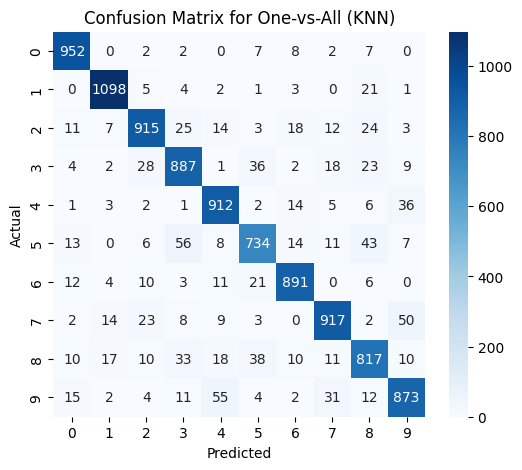

Bagging model accuracy for One-vs-One (KNN): 0.9185
Classification Report for One-vs-One (KNN):

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.93      0.91      0.92      1032
           3       0.90      0.89      0.90      1010
           4       0.90      0.94      0.92       982
           5       0.88      0.86      0.87       892
           6       0.94      0.95      0.95       958
           7       0.92      0.92      0.92      1028
           8       0.89      0.86      0.87       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



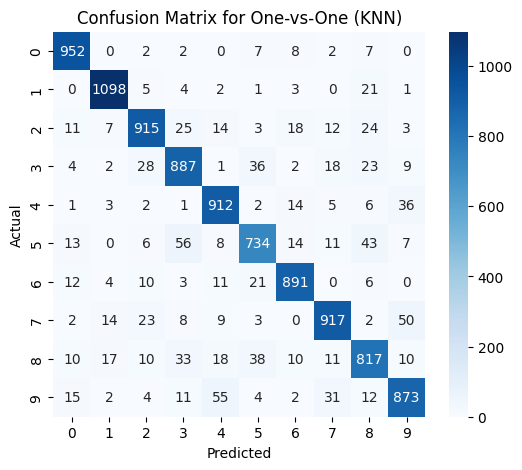


Model: SVM, Bagging Accuracy: 0.9268

Model: One-vs-All (SVM), Bagging Accuracy: 0.9187

Model: One-vs-One (SVM), Bagging Accuracy: 0.9228

Model: Random Forest, Bagging Accuracy: 0.9146

Model: One-vs-All (Random Forest), Bagging Accuracy: 0.9149

Model: One-vs-One (Random Forest), Bagging Accuracy: 0.9139

Model: Naive Bayes, Bagging Accuracy: 0.8800

Model: One-vs-All (Naive Bayes), Bagging Accuracy: 0.8814

Model: One-vs-One (Naive Bayes), Bagging Accuracy: 0.8798

Model: Logistic Regression, Bagging Accuracy: 0.8889

Model: One-vs-All (Logistic Regression), Bagging Accuracy: 0.8803

Model: One-vs-One (Logistic Regression), Bagging Accuracy: 0.8936

Model: Decision Tree, Bagging Accuracy: 0.8987

Model: One-vs-All (Decision Tree), Bagging Accuracy: 0.6811

Model: One-vs-One (Decision Tree), Bagging Accuracy: 0.9067

Model: KNN, Bagging Accuracy: 0.9200

Model: One-vs-All (KNN), Bagging Accuracy: 0.9172

Model: One-vs-One (KNN), Bagging Accuracy: 0.9185


In [59]:
bagging_results = []

lda = LDA(n_components=9)
X_train_reduced = lda.fit_transform(X_train_scaled, y_train)
X_test_reduced = lda.transform(X_test_scaled)

for result in results:
    best_model = result['best_model']
    
    bagging_model = BaggingClassifier(estimator=best_model, n_estimators=10, random_state=42, n_jobs=-1)
    
    bagging_model.fit(X_train_reduced, y_train)

    y_pred_bagging = bagging_model.predict(X_test_reduced)

    bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
    print(f"Bagging model accuracy for {result['model_name']}: {bagging_accuracy:.4f}")

    print(f"Classification Report for {result['model_name']}:\n")
    print(classification_report(y_test, y_pred_bagging))

    cm = confusion_matrix(y_test, y_pred_bagging)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {result['model_name']}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    bagging_results.append({
        'model_name': result['model_name'],
        'bagging_accuracy': bagging_accuracy,
        'bagging_model': bagging_model
    })

for result in bagging_results:
    print(f"\nModel: {result['model_name']}, Bagging Accuracy: {result['bagging_accuracy']:.4f}")


## Ensemble learning(Boosting)
### Ada-Boost

AdaBoost model accuracy for Decision Tree: 0.9147
Classification Report for Decision Tree (AdaBoost):

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.93      0.92       982
           5       0.88      0.84      0.86       892
           6       0.94      0.94      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.86      0.87      0.86       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



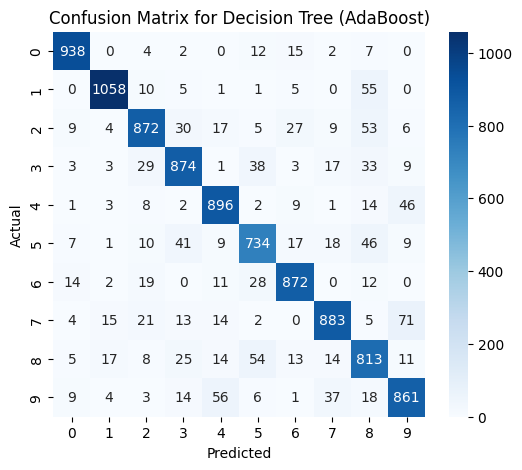

AdaBoost model accuracy for One-vs-All (Decision Tree): 0.8575
Classification Report for One-vs-All (Decision Tree) (AdaBoost):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.94      0.94      0.94      1135
           2       0.87      0.83      0.85      1032
           3       0.81      0.82      0.82      1010
           4       0.85      0.88      0.87       982
           5       0.78      0.78      0.78       892
           6       0.90      0.90      0.90       958
           7       0.88      0.89      0.88      1028
           8       0.77      0.77      0.77       974
           9       0.84      0.81      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



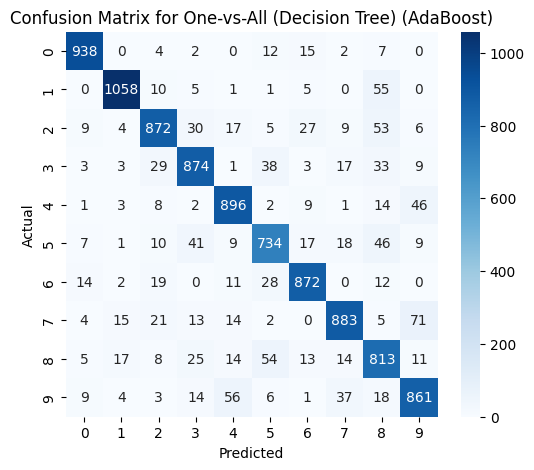

AdaBoost model accuracy for One-vs-One (Decision Tree): 0.8575
Classification Report for One-vs-One (Decision Tree) (AdaBoost):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.94      0.94      0.94      1135
           2       0.87      0.83      0.85      1032
           3       0.81      0.82      0.82      1010
           4       0.85      0.88      0.87       982
           5       0.78      0.78      0.78       892
           6       0.90      0.90      0.90       958
           7       0.88      0.89      0.88      1028
           8       0.77      0.77      0.77       974
           9       0.84      0.81      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



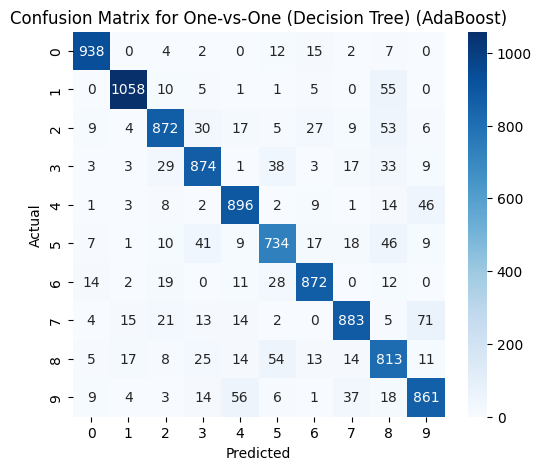

AdaBoost model accuracy for Naive Bayes: 0.8801
Classification Report for Naive Bayes (AdaBoost):

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.96      0.93      0.94      1135
           2       0.89      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



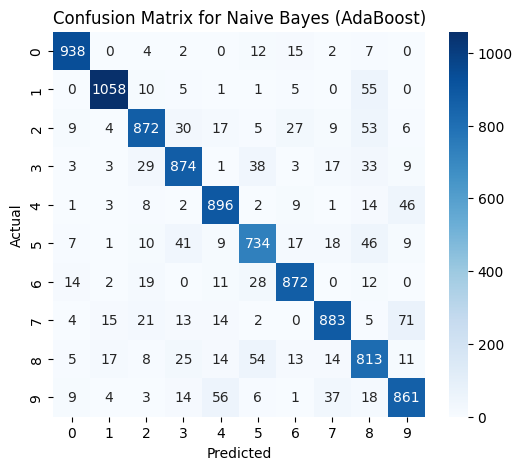

AdaBoost model accuracy for One-vs-All (Naive Bayes): 0.8801
Classification Report for One-vs-All (Naive Bayes) (AdaBoost):

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.96      0.93      0.94      1135
           2       0.89      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



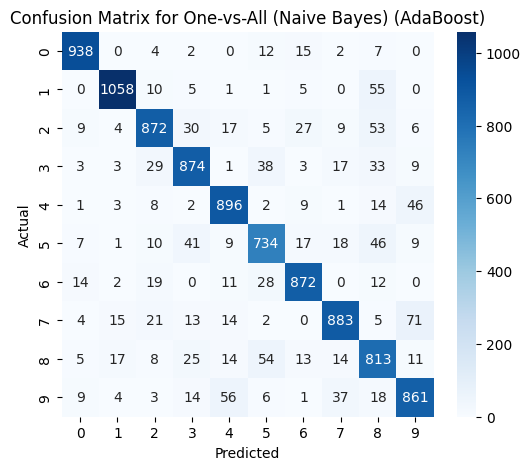

AdaBoost model accuracy for One-vs-One (Naive Bayes): 0.8801
Classification Report for One-vs-One (Naive Bayes) (AdaBoost):

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.96      0.93      0.94      1135
           2       0.89      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.86      0.88      1028
           8       0.77      0.83      0.80       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



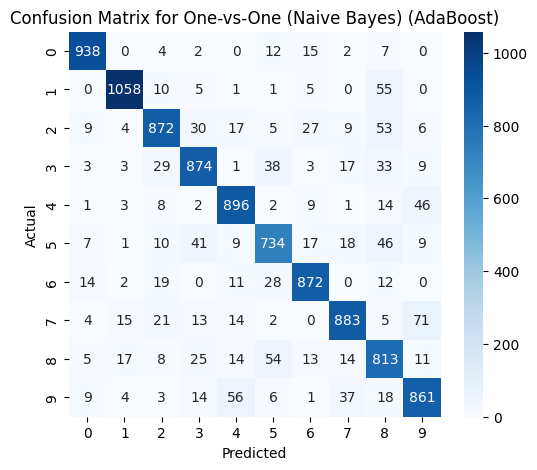

In [55]:
ensemble_results = []

lda = LDA(n_components=9)
X_train_reduced = lda.fit_transform(X_train_scaled, y_train)
X_test_reduced = lda.transform(X_test_scaled)

decision_tree_models = [result for result in results if 'Decision Tree' in result['model_name']]
naive_bayes_models = [result for result in results if 'Naive Bayes' in result['model_name']]

models_to_process = decision_tree_models + naive_bayes_models

for result in models_to_process:
    best_model = result['best_model']
    
    if isinstance(best_model, (OneVsRestClassifier, OneVsOneClassifier)):
        base_classifier = best_model.estimator  # Get the base classifier from the OneVsRest or OneVsOne classifier
    else:
        base_classifier = best_model
    
    adaboost_model = AdaBoostClassifier(
        estimator=base_classifier,   
        n_estimators=50,             
        learning_rate=1.0,          
        random_state=42,
        algorithm='SAMME'
    )
    
    adaboost_model.fit(X_train_reduced, y_train)
    y_pred_adaboost = adaboost_model.predict(X_test_reduced)
    
    adaboost_accuracy = accuracy_score(y_test, y_pred_adaboost)
    print(f"AdaBoost model accuracy for {result['model_name']}: {adaboost_accuracy:.4f}")
    
    print(f"Classification Report for {result['model_name']} (AdaBoost):\n")
    print(classification_report(y_test, y_pred_adaboost))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_adaboost, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {result['model_name']} (AdaBoost)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
